<a href="https://colab.research.google.com/github/nidhaloff/RNN_MNIST/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import keras
from keras import backend as K
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

# run keras model on google GPU
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
K.tensorflow_backend._get_available_gpus()

# run pytorch on GPU
DEVICE = "cuda" if torch.cuda.is_available else "cpu"

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [0]:
class SingleRNN(nn.Module):
    def __init__(self, n_features, n_hidden):
        super().__init__()
        self.wx = torch.randn(n_features, n_hidden)    # 4 X 1
        self.wy = torch.randn(n_hidden, n_hidden)    # 1 X 1
        self.b = torch.zeros(1, n_hidden)    # 1 X 1
        
                
    def forward(self, x0, x1):
        self.y0 = torch.tanh(torch.mm(x0, self.wx) + self.b)    # 4 X 1
        self.y1 = torch.tanh(torch.mm(self.y0, self.wy) + torch.mm(x1, self.wx) + self.b)    # 4 X 1
        return self.y0, self.y1        

In [10]:
N_INPUT = 4
N_NEURONS = 1

X0_batch = torch.tensor([[0,1,2,0], [3,4,5,0], 
                         [6,7,8,0], [9,0,1,0]],
                        dtype = torch.float) #t=0 => 4 X 4

X1_batch = torch.tensor([[9,8,7,0], [0,0,0,0], 
                         [6,5,4,0], [3,2,1,0]],
                        dtype = torch.float) #t=1 => 4 X 4

model = SingleRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

print(Y0_val, Y1_val)

tensor([[-0.8239],
        [-1.0000],
        [-1.0000],
        [-0.9995]]) tensor([[-1.0000],
        [-0.5734],
        [-1.0000],
        [-0.9996]])


In [12]:
N_INPUT = 3 # number of features in input
N_NEURONS = 5 # number of units in layer

X0_batch = torch.tensor([[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        dtype = torch.float) #t=0 => 4 X 3

X1_batch = torch.tensor([[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]],
                        dtype = torch.float) #t=1 => 4 X 3

model = SingleRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

print(Y0_val, Y1_val)


tensor([[-0.5049,  0.9933,  0.0782,  0.9982,  0.9973],
        [-0.9630,  1.0000,  0.9903,  1.0000,  1.0000],
        [-0.9978,  1.0000,  0.9999,  1.0000,  1.0000],
        [-0.9040,  0.9993,  1.0000,  0.8347,  0.9155]]) tensor([[-0.9991,  1.0000,  1.0000,  1.0000,  1.0000],
        [-0.7175,  0.9958,  0.9993, -0.2401, -0.9990],
        [-0.9968,  1.0000,  1.0000,  1.0000,  1.0000],
        [-0.9566,  1.0000,  1.0000,  0.9999,  0.0133]])


In [14]:
# pytorch built in RNN Cell:
rnn = nn.RNNCell(3, 5)

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1

hx = torch.randn(4, 5)
output = []

for i in range(len(X_batch)):
    hx = rnn(X_batch[i], hx)
    output.append(hx)
    
print(output)

[tensor([[ 0.2182,  0.4518, -0.5786,  0.4152,  0.6755],
        [ 0.9895,  0.9976, -0.6236, -0.0116,  0.5305],
        [ 1.0000,  1.0000, -0.9585, -0.8776,  0.6815],
        [-0.1393,  0.9962,  0.5679, -0.2063, -0.9946]], grad_fn=<TanhBackward>), tensor([[ 0.9998,  1.0000, -0.7478, -0.9702, -0.9623],
        [-0.5656,  0.7973, -0.0205, -0.2658,  0.5591],
        [ 0.9809,  0.9999, -0.7214, -0.7384, -0.8417],
        [ 0.6687,  0.9779, -0.4783, -0.1812, -0.6799]], grad_fn=<TanhBackward>)]


In [0]:
# now build a clean version of RNN:

class CleanRNN(nn.Module):
    def __init__(self, batch_size, n_input, n_neuron):
        super().__init__()
        rnn = nn.RNNCell(n_input, n_neuron)
        self.hx = torch.randn(batch_size, n_neuron)
        
    def forward(self, x):
        output = []
        
        for i in range(2):
            self.hx = rnn(x[i], self.hx)
            output.append(self.hx)
            
        return output, self.hx

        

In [16]:
    
FIXED_BATCH_SIZE = 4 # our batch size is fixed for now
N_INPUT = 3
N_NEURONS = 5

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1

model = CleanRNN(FIXED_BATCH_SIZE, N_INPUT, N_NEURONS)
output_val, states_val = model(X_batch)
print(output_val) # contains all output for all timesteps
print(states_val) # contains values for final state or final timestep, i.e., t=1

[tensor([[ 0.5770,  0.9237, -0.0655, -0.5909,  0.7333],
        [ 0.9965,  0.9999, -0.8320, -0.7910,  0.6123],
        [ 0.9999,  1.0000,  0.0272, -0.9942, -0.5340],
        [-0.1309,  0.9973, -0.6871,  0.6773, -0.9782]], grad_fn=<TanhBackward>), tensor([[ 0.9998,  1.0000, -0.8858, -0.9562, -0.9469],
        [-0.7263,  0.6849, -0.2729,  0.0271,  0.5572],
        [ 0.9938,  0.9999, -0.7930, -0.4621, -0.7834],
        [ 0.6282,  0.9608,  0.2222, -0.3866, -0.8203]], grad_fn=<TanhBackward>)]
tensor([[ 0.9998,  1.0000, -0.8858, -0.9562, -0.9469],
        [-0.7263,  0.6849, -0.2729,  0.0271,  0.5572],
        [ 0.9938,  0.9999, -0.7930, -0.4621, -0.7834],
        [ 0.6282,  0.9608,  0.2222, -0.3866, -0.8203]], grad_fn=<TanhBackward>)


In [17]:
# use RNN to classify images from the MNIST DAtaset
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20089009.98it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 331376.23it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 5267918.61it/s]                           
8192it [00:00, 132090.35it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


torch.Size([64, 1, 28, 28])
(3, 242, 242)


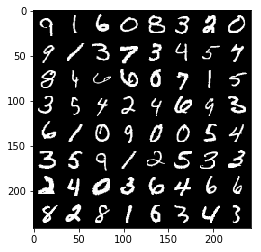

In [21]:
# explore the dataset
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [0]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [29]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
print(images.shape)
print(images.view(-1, 28, 28).shape)

logits = model(images.view(-1, 28,28))

print(logits.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 28, 28])
torch.Size([64, 10])


In [0]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [31]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.6670 | Train Accuracy: 77.98
Epoch:  1 | Loss: 0.3059 | Train Accuracy: 90.68
Epoch:  2 | Loss: 0.2372 | Train Accuracy: 92.71
Epoch:  3 | Loss: 0.1975 | Train Accuracy: 93.75
Epoch:  4 | Loss: 0.1767 | Train Accuracy: 94.52
Epoch:  5 | Loss: 0.1639 | Train Accuracy: 94.93
Epoch:  6 | Loss: 0.1484 | Train Accuracy: 95.28
Epoch:  7 | Loss: 0.1382 | Train Accuracy: 95.62
Epoch:  8 | Loss: 0.1264 | Train Accuracy: 95.89
Epoch:  9 | Loss: 0.1267 | Train Accuracy: 96.01


In [32]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 95.46
